In [ ]:
# Execute this cell to install dependencies
%pip install sf-hamilton[visualization]

# Example of using with_columns for Pandas [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dagworks-inc/hamilton/blob/main/examples/pandas/with_columns/notebook.ipynb) [![GitHub badge](https://img.shields.io/badge/github-view_source-2b3137?logo=github)](https://github.com/dagworks-inc/hamilton/blob/main/examples/pandas/with_columns/notebook.ipynb)

This allows you to efficiently run groups of map operations on a dataframe.
Here's an example of calling it -- if you've seen `@subdag`, you should be familiar with the concepts.

In [1]:
%reload_ext hamilton.plugins.jupyter_magic
from hamilton import driver
import my_functions

my_builder = driver.Builder().with_modules(my_functions).with_config({"case":"thousands"})
output_node = ["final_df"]

/Users/jernejfrank/miniconda3/envs/hamilton/lib/python3.10/site-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


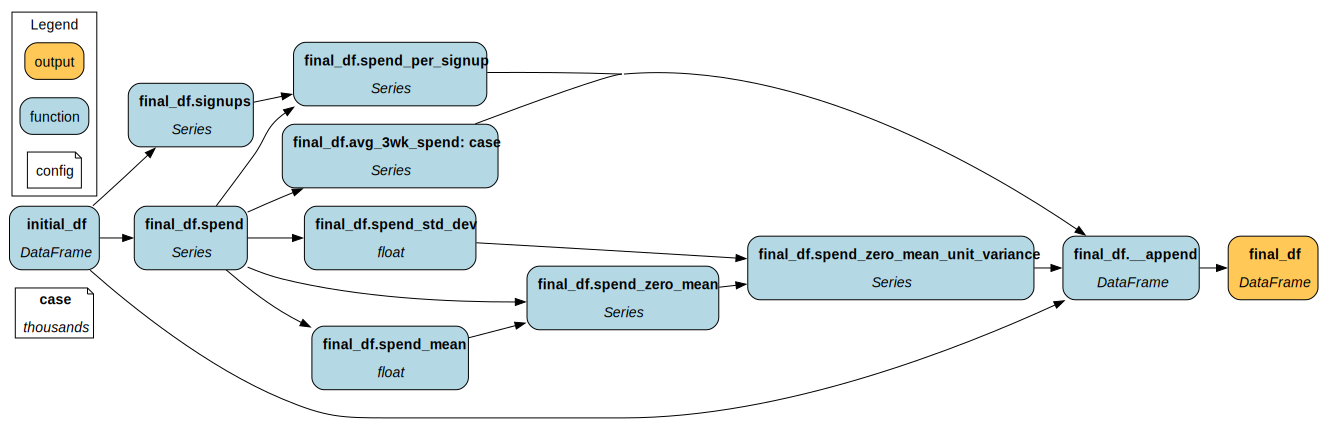

In [2]:
%%cell_to_module with_columns_example --builder my_builder --display --execute output_node
import pandas as pd
from hamilton.plugins.h_pandas import with_columns
import my_functions

output_columns = [
    # "spend",
    # "signups",
    "avg_3wk_spend",
    "spend_per_signup",
    "spend_zero_mean_unit_variance",
]

def initial_df()->pd.DataFrame:
    return pd.DataFrame.from_dict(
        { 
            "signups": pd.Series([1, 10, 50, 100, 200, 400]),
            "spend": pd.Series([10, 10, 20, 40, 40, 50])*1e6,
            }
            )

# the with_columns call
@with_columns(
    *[my_functions],
    columns_to_pass=["spend", "signups"], # The columns to select from the dataframe
    select=output_columns, # The columns to append to the dataframe
    # config_required = ["a"]
)
def final_df(initial_df: pd.DataFrame) -> pd.DataFrame:
    return initial_df

   signups       spend  avg_3wk_spend  spend_per_signup  \
0        1  10000000.0            NaN        10000000.0   
1       10  10000000.0            NaN         1000000.0   
2       50  20000000.0      13.333333          400000.0   
3      100  40000000.0      23.333333          400000.0   
4      200  40000000.0      33.333333          200000.0   
5      400  50000000.0      43.333333          125000.0   

   spend_zero_mean_unit_variance  
0                      -1.064405  
1                      -1.064405  
2                      -0.483821  
3                       0.677349  
4                       0.677349  
5                       1.257934  


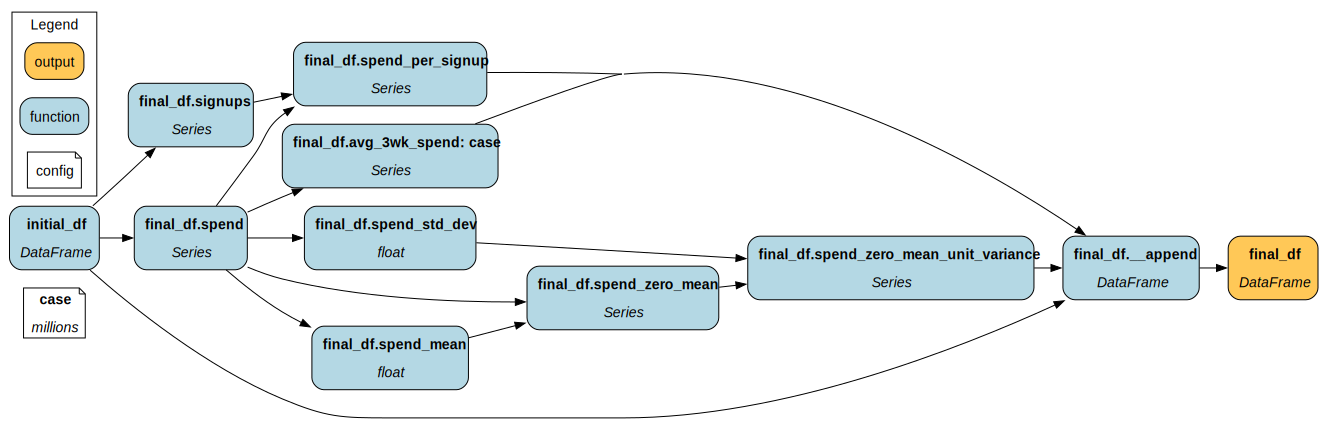

In [3]:
import with_columns_example
dr = driver.Builder().with_modules(my_functions, with_columns_example).with_config({"case":"millions"}).build()
print(dr.execute(final_vars=["final_df"])["final_df"])
dr.visualize_execution(final_vars=["final_df"])


# We can also run it async

In [4]:
%reload_ext hamilton.plugins.jupyter_magic

In [5]:
%%cell_to_module with_columns_async

import asyncio
import pandas as pd
from hamilton.plugins.h_pandas import with_columns

async def data_input() -> pd.DataFrame:
    await asyncio.sleep(0.0001)
    return pd.DataFrame({
        "a": [1, 2, 3],
        "b": [4, 5, 6],
        "c": [7, 8, 9]
    })


async def multiply_a(a: pd.Series) -> pd.Series:
    await asyncio.sleep(0.0001)
    return a * 10


async def mean_b(b: pd.Series) -> pd.Series:
    await asyncio.sleep(5)
    return b.mean()

async def a_plus_b(a: pd.Series, b: pd.Series) -> pd.Series:
    await asyncio.sleep(1)
    return a + b

async def multiply_a_plus_mean_b(multiply_a: pd.Series, mean_b: pd.Series) -> pd.Series:
    await asyncio.sleep(0.0001)
    return multiply_a + mean_b


@with_columns(
        multiply_a,mean_b,a_plus_b, multiply_a_plus_mean_b,
        columns_to_pass=["a", "b"]
)
def final_df(data_input: pd.DataFrame) -> pd.DataFrame:
    return data_input

In [6]:
import asyncio
from hamilton import async_driver
import with_columns_async

async def main():
    await asyncio.sleep(2)
    dr = (await async_driver.Builder()
            .with_modules(with_columns_async)
            .with_config({"case":"millions"})
            .build())
    results = await dr.execute(["final_df"])
    print(results["final_df"])

await main()


   a  b  c  multiply_a  mean_b  a_plus_b  multiply_a_plus_mean_b
0  1  4  7          10     5.0         5                    15.0
1  2  5  8          20     5.0         7                    25.0
2  3  6  9          30     5.0         9                    35.0
